# Lab 7 - Image Classification with Convolutional Neural Networks


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization, GlobalAveragePooling2D, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import tensorflow.image as tfi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

2024-02-27 11:47:20.488827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
images_org = []
images_mask = []
folder_img = "segmentation_images/"
all_files = os.listdir(folder_img)
all_files.sort()

for file in all_files:
    if "fuse" in file:
        images_mask.append(img_to_array(load_img(folder_img + file)))
    elif "fuse" not in file and "save" not in file:
        images_org.append(img_to_array(load_img(folder_img + file)))

In [5]:
X = np.array(images_org)
y = np.array(images_mask)

In [6]:
X = X / 255
X = tfi.resize(X, [256, 256])
y = y / 255
y = tfi.resize(y, [256, 256])

2024-02-27 11:47:34.125770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-27 11:47:34.125835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


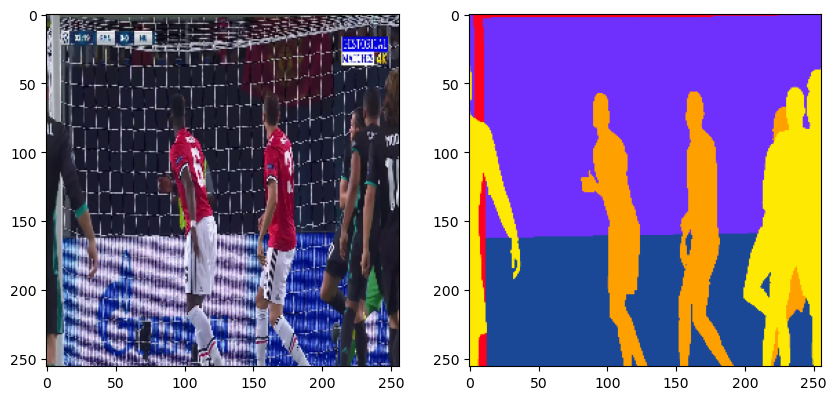

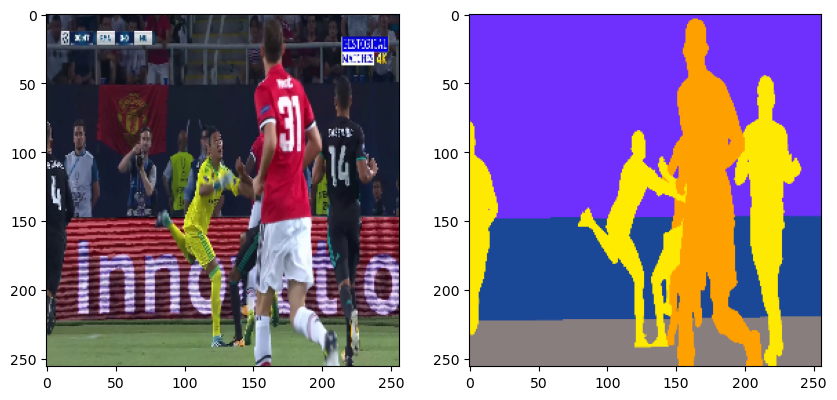

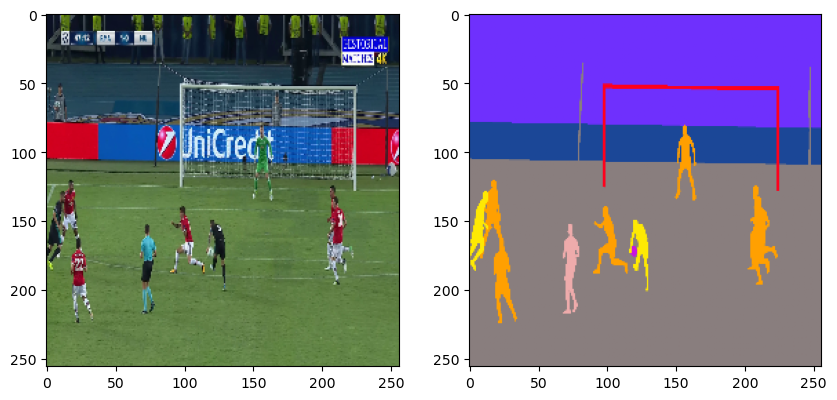

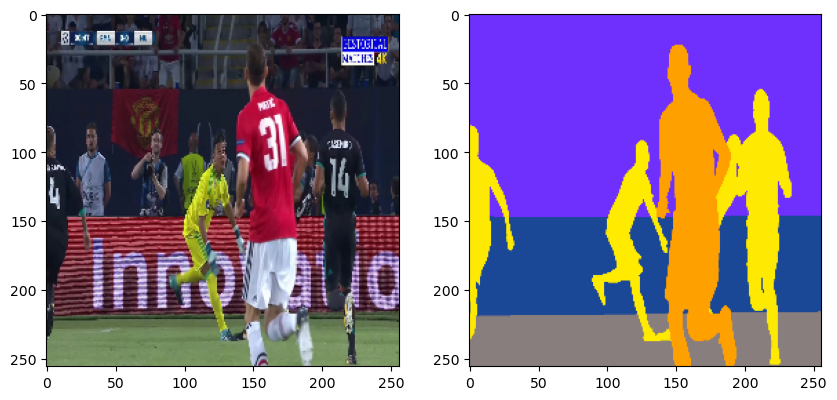

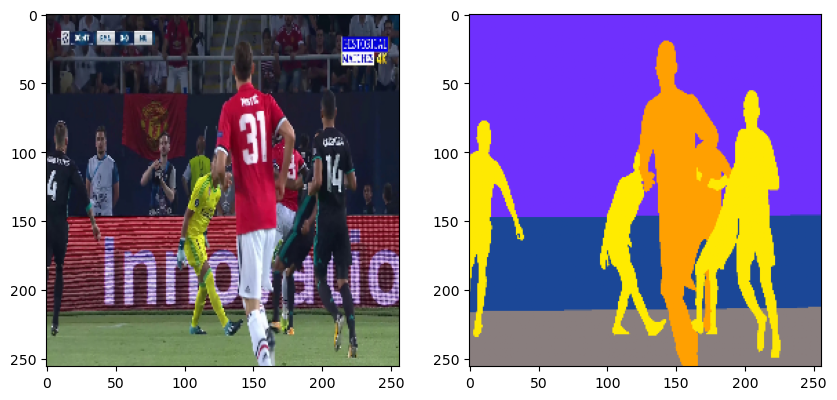

In [7]:
for i in range(5):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(X[i])
    plt.subplot(1, 2, 2)
    plt.imshow(y[i])
    plt.show()

In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
X.shape, y.shape

((100, 256, 256, 3), (100, 256, 256, 3))

In [10]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, filters, rate=0.2, pooling=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.bn = BatchNormalization()
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()
    
    def call(self, X):
        x = self.c2(self.drop(self.c1(self.bn(X))))
        if self.pooling:
            y = self.pool(x)
            return x, y
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "rate":self.rate,"pooling":self.pooling}

In [11]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn = BatchNormalization()
        self.skip = Concatenate()
        self.net = Encoder(filters, rate, pooling=False)
    
    def call(self, X):
        x, skip_x = X
        y = self.cT(self.bn(x))
        y = self.net(self.skip([y, skip_x]))
        return y
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "rate":self.rate}

In [12]:
InputL = tf.keras.layers.Input(shape=(256, 256, 3))

c1, p1 = Encoder(filters=64,  rate=0.1, name="Encoder1")(InputL)
c2, p2 = Encoder(filters=128, rate=0.1, name="Encoder2")(p1)
c3, p3 = Encoder(filters=256, rate=0.2, name="Encoder3")(p2)
c4, p4 = Encoder(filters=512, rate=0.2, name="Encoder4")(p3)

# Encoding Layer
encodings = Encoder(filters=512, rate=0.3, pooling=False, name="Encoding")(p4)

# Decoder Block
d = Decoder(512, 0.2, name='Decoder1')([encodings, c4])
d = Decoder(256, 0.2, name='Decoder2')([d, c3])
d = Decoder(128, 0.1, name='Decoder3')([d, c2])
d = Decoder(64, 0.1, name='Decoder4')([d, c1])
conv_out = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid', name="Segmentator")(d)
model = tf.keras.Model(InputL, conv_out, name="UNet_Segmentator")

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNet_Segmentator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder1 (Encoder)             ((None, 256, 256, 6  38732       ['input_1[0][0]']                
                                4),                                                               
                                 (None, 128, 128, 6                                               
                                4))                                                               
                                                                                   

In [14]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)]

In [15]:
model.fit(X, y, epochs=10, batch_size=32, validation_data=(X, y), callbacks=callbacks)

Epoch 1/10


2024-02-27 11:47:42.317744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-27 11:47:42.834083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


4/4 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.4956

2024-02-27 11:48:02.325728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 26s 4s/step - loss: 0.7596 - accuracy: 0.4956 - val_loss: 3.3528 - val_accuracy: 0.5094
Epoch 2/10
4/4 [==============================] - 10s 3s/step - loss: 0.6842 - accuracy: 0.5826 - val_loss: 12.2097 - val_accuracy: 0.5658
Epoch 3/10
4/4 [==============================] - 10s 3s/step - loss: 0.6554 - accuracy: 0.6841 - val_loss: 13.0518 - val_accuracy: 0.4822
Epoch 4/10
4/4 [==============================] - 11s 3s/step - loss: 0.6379 - accuracy: 0.7313 - val_loss: 21.0591 - val_accuracy: 0.5910
Epoch 4: early stopping


In [16]:
model.evaluate(X, y)

4/4 [==============================] - 2s 493ms/step - loss: 3.3528 - accuracy: 0.5094


[3.3527965545654297, 0.509428083896637]

In [24]:
pred = model.predict(X)

4/4 [==============================] - 1s 478ms/step


In [27]:
pred.shape

(100, 256, 256, 3)

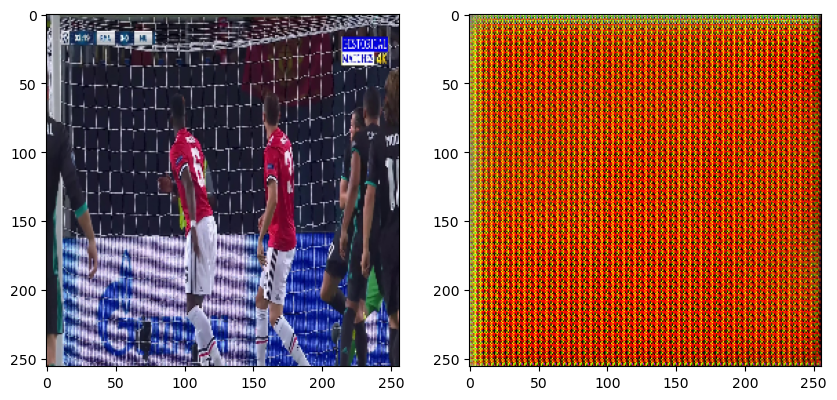

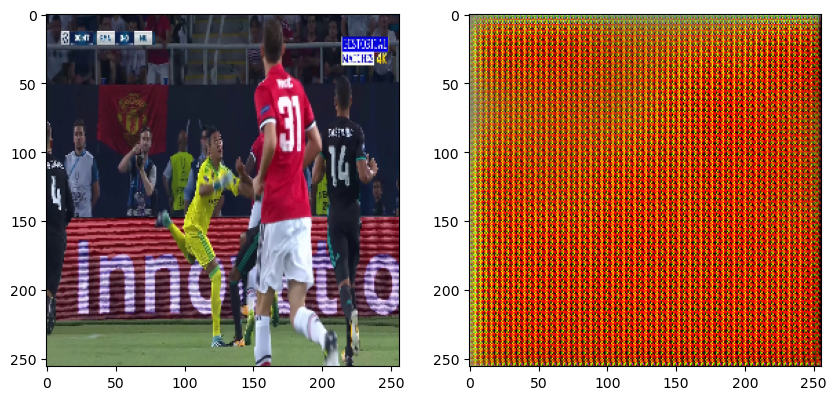

In [25]:
for i in range(2):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(X[i])
    plt.subplot(1, 2, 2)
    plt.imshow(pred[i])
    plt.show()